In [21]:
#Modelo DistilBETO

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import re,string
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from string import punctuation
from nltk.corpus import wordnet


MAX_LEN = 85

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df_train = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/train.csv')
print(df_train.shape)
df_train.isnull().sum()
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()
df_train['review'] = df_train['text']
df_train.drop('text', axis=1, inplace=True)
df_train['label'] = df_train['sentiment']
df_train.drop('sentiment', axis=1, inplace=True)

df_dev = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/dev.csv')
print(df_dev.shape)
df_dev.isnull().sum()
df_dev.sentiment.replace("P" , 2 , inplace = True)
df_dev.sentiment.replace("N" , 0 , inplace = True)
df_dev.sentiment.replace("NEU" , 1, inplace = True)
df_dev['review'] = df_dev['text']
df_dev.drop('text', axis=1, inplace=True)
df_dev['label'] = df_dev['sentiment']
df_dev.drop('sentiment', axis=1, inplace=True)

df_test = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/test.csv')
print(df_dev.shape)
df_test.isnull().sum()
df_test.sentiment.replace("P" , 2 , inplace = True)
df_test.sentiment.replace("N" , 0 , inplace = True)
df_test.sentiment.replace("NEU" , 1, inplace = True)
df_test['review'] = df_test['text']
df_test.drop('text', axis=1, inplace=True)
df_test['label'] = df_test['sentiment']
df_test.drop('sentiment', axis=1, inplace=True)


(4340, 2)
(1447, 2)
(1447, 2)


In [2]:
X_train = df_train.iloc[:, 0]
y_train = df_train.iloc[:, 1]
X_dev = df_dev.iloc[:, 0]
y_dev = df_dev.iloc[:, 1]

In [3]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('dccuchile/distilbert-base-spanish-uncased',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_dev_inputs, X_dev_masks = preprocessing(X_dev)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 71


In [4]:
#Data loaders
batch_size = 8

y_train_labels = torch.tensor(y_train.values)
y_dev_labels = torch.tensor(y_dev.values)

def dataloader(x_inputs, x_masks, y_labels, is_train_split):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    if is_train_split:
	    sampler = RandomSampler(data)
    else:
    	sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels, True)
val_dataloader = dataloader(X_dev_inputs, X_dev_masks, y_dev_labels, False)

In [5]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('dccuchile/distilbert-base-spanish-uncased', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5)

epochs=4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at dccuchile/distilbert-base-spanish-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/distilbert-base-spanish-uncased and are newly initialized: ['pre_classifier.wei

In [6]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [7]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (31002, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (

In [8]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [9]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = outputs[0]
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        loss = outputs [0]
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs [1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    543.    Elapsed: 0:01:47.
  Batch    80  of    543.    Elapsed: 0:03:27.
  Batch   120  of    543.    Elapsed: 0:05:02.
  Batch   160  of    543.    Elapsed: 0:06:39.
  Batch   200  of    543.    Elapsed: 0:08:14.
  Batch   240  of    543.    Elapsed: 0:09:48.
  Batch   280  of    543.    Elapsed: 0:11:21.
  Batch   320  of    543.    Elapsed: 0:13:00.
  Batch   360  of    543.    Elapsed: 0:14:36.
  Batch   400  of    543.    Elapsed: 0:16:12.
  Batch   440  of    543.    Elapsed: 0:17:46.
  Batch   480  of    543.    Elapsed: 0:19:21.
  Batch   520  of    543.    Elapsed: 0:20:51.

  Average training loss: 0.86
  Training epcoh took: 0:21:42

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.82
  Validation took: 0:01:49

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    543.    Elapsed: 0:01:32.
  Batch    80  of    543.    Elapsed: 0:03:02.
  Batch   120  of    543.    Elapsed: 0:04:33.
  Batch  

In [10]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.86,0.82,0.60,0:21:42,0:01:49
2,0.57,0.81,0.66,0:20:35,0:01:48
3,0.31,1.34,0.65,0:20:38,0:01:49
4,0.16,1.60,0.65,0:20:36,0:01:49


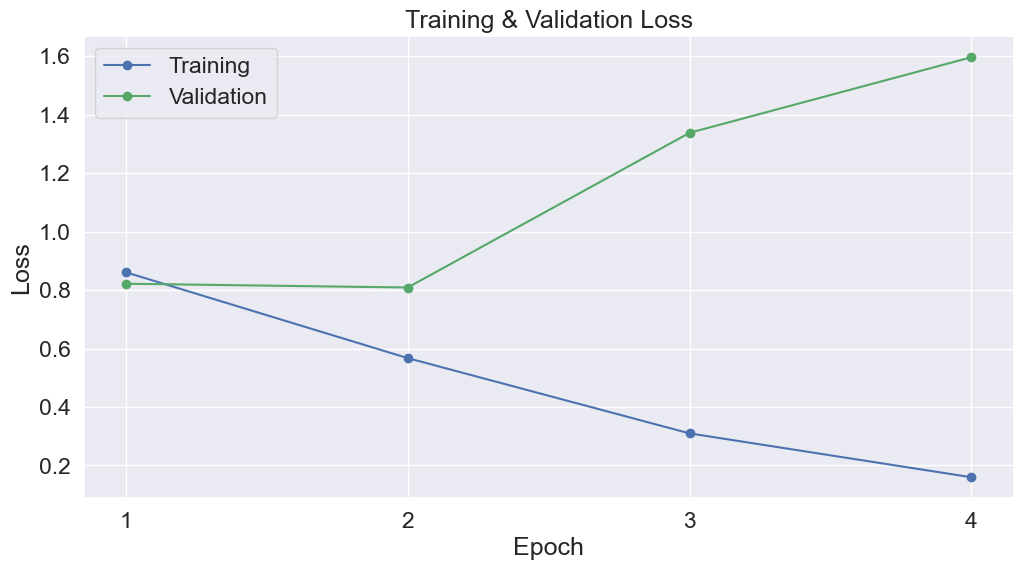

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [22]:
#Guardamos el modelo
model.save_pretrained('/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/model')

tokenizer.save_pretrained('/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/tokenizer')

('/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/tokenizer/tokenizer_config.json',
 '/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/tokenizer/special_tokens_map.json',
 '/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/tokenizer/vocab.txt',
 '/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/tokenizer/added_tokens.json')

In [23]:
X_test = df_dev.iloc[:, 0]
y_test = df_dev.iloc[:, 1]

In [24]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/tokenizer',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_test_inputs, X_test_masks = preprocessing(X_test)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_test_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 53


In [25]:
#Data loaders
batch_size = 32

y_test_labels = torch.tensor(y_test.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

test_dataloader = dataloader(X_test_inputs, X_test_masks, y_test_labels)

In [26]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('/Volumes/NFANLO/TFG/Overfitted/DistilBetoOverfitting/model', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5)

epochs=1

total_steps = len(test_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [28]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 1 =======


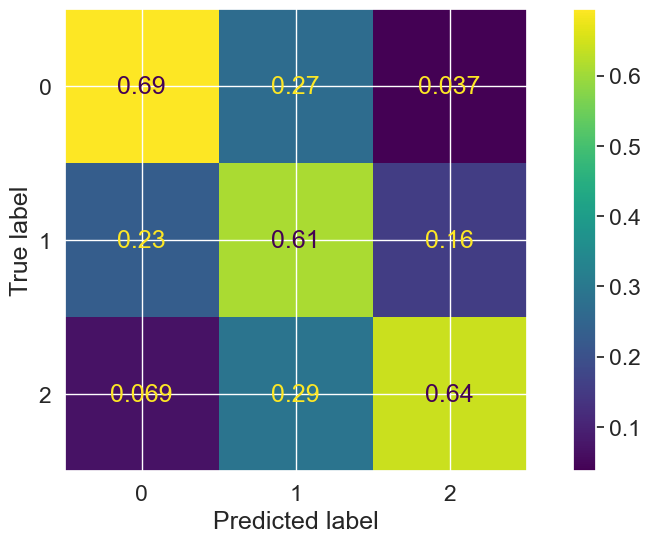

              precision    recall  f1-score   support

           1       0.76      0.69      0.73       599
           2       0.49      0.61      0.54       440
           3       0.74      0.64      0.69       408

    accuracy                           0.65      1447
   macro avg       0.66      0.65      0.65      1447
weighted avg       0.67      0.65      0.66      1447

f1 score macro: 0.6532465472178758
accuracy score: 0.6544574982722875
precision score: 0.6649967686805222
recall score: 0.6493371057129281


In [29]:
#Definimos la funcion para pasar el test por el modelo y entregar los resultados
all_logits_test = []
all_labels_test = []
avg_train_loss_test = []

def training(n_epochs, test_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0

        # Evalua el data para un epoch mas
        for step, batch in enumerate(test_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits_test.extend(predict_labels.tolist())
            all_labels_test.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels_test, all_logits_test, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()
  
    target_names = ['1', '2', '3']
    print(classification_report(all_labels_test, all_logits_test, target_names=target_names))
    
    print("f1 score macro:", f1_score(all_labels_test, all_logits_test, average='macro'))
    print("accuracy score:", accuracy_score(all_labels_test, all_logits_test))
    print("precision score:", precision_score(all_labels_test, all_logits_test, average='macro'))
    print("recall score:", recall_score(all_labels_test, all_logits_test, average='macro'))




#Llamamos a la funcion para entrenar el modelo
training(epochs, test_dataloader)        